In [ ]:
import tensorflow as tf
from tensorflow.keras import models , layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
dataset, info = tfds.load(
   'oxford_iiit_pet',
   split=['train','test[:50%]','test[50%:]'],
   with_info = True


)

dataset_train_original = dataset[0]
dataset_validate_original = dataset[1]
dataset_test_original = dataset[2]
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQEQPVH/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQEQPVH/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

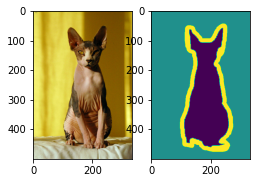

In [ ]:
def render_sample(image, segmentation_mask, predicted_mask=None):
  plt.subplot(1,3,1)
  plt.imshow(image)
  plt.subplot(1, 3, 2)
  plt.imshow(segmentation_mask)
  if predicted_mask is not None:
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
  plt.show()
  plt.close()

for sample in dataset_train_original.shuffle(10).take(1):
  image = sample['image'].numpy()
  segmentation_mask = sample['segmentation_mask'].numpy().squeeze()
  render_sample(image, segmentation_mask)
  

In [ ]:
for sample in dataset_test_original.take(1):
  segmentation_mask = sample['segmentation_mask']
  print(set(list(segmentation_mask.numpy().flatten())))

{1, 2, 3}


In [ ]:
image_size = (200,200)
num_classes = 3


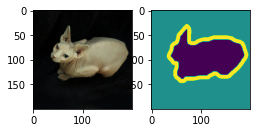

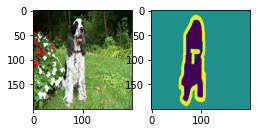

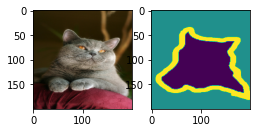

In [ ]:
def encode(sample):
  #split image nd mask
  image = sample['image']
  segmentation_mask = sample['segmentation_mask']

  #Normalize and resize image
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.image.resize(image, image_size)

  #Resize mask and shift classes
  segmentation_mask = tf.image.resize(segmentation_mask, image_size)
  segmentation_mask = segmentation_mask-1


  return image, segmentation_mask
dataset = dataset_train_original.map(lambda sample: encode(sample))

num_samples = 8
for image, segmentation_mask in dataset.take(num_classes):
  render_sample(image.numpy(), segmentation_mask.numpy().squeeze())

In [ ]:
dataset_train = dataset_train_original.map(lambda sample: encode(sample)).cache().shuffle(4000).batch(64)
dataset_validate = dataset_validate_original.map(lambda sample: encode(sample)).cache().batch(64)
dataset_test = dataset_test_original.map(lambda sample: encode(sample)).cache().batch(64)

In [ ]:
model = models.Sequential()
model.add(layers.Input(shape= image_size+(3,)))

model.add(layers.Conv2D(64, 3, strides=2, activation = 'relu', padding='same'))
model.add(layers.Conv2D(64,3, activation='relu', padding='same'))

model.add(layers.Conv2D(128, 3, strides=2, activation = 'relu', padding='same'))
model.add(layers.Conv2D(128,3, activation='relu', padding='same'))

model.add(layers.Conv2D(256, 3, strides=2, activation = 'relu', padding='same'))
model.add(layers.Conv2D(256,3, activation='relu', padding='same'))

model.add(layers.Conv2DTranspose(256, 3, activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(256, 3,strides=2, activation='relu', padding='same'))

model.add(layers.Conv2DTranspose(256, 3, activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(256, 3,strides=2, activation='relu', padding='same'))

model.add(layers.Conv2DTranspose(64, 3, activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(64, 3,strides=2, activation='relu', padding='same'))

model.add(layers.Conv2DTranspose(num_classes, 3, activation='softmax', padding='same'))


model.summary()

model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    dataset_train,
    epochs=50,
    validation_data=dataset_validate


)

history_dictionary['mlp'] = history.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 256)       590080    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 25, 25, 256)      5

KeyboardInterrupt: ignored

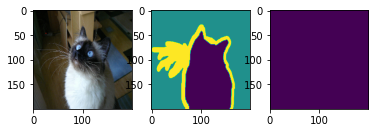

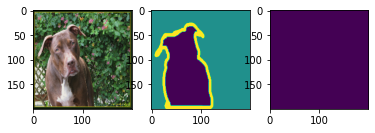

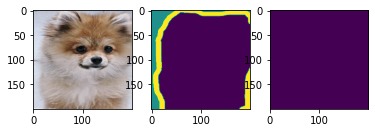

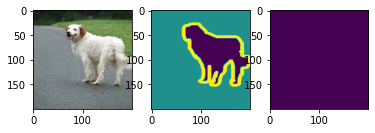

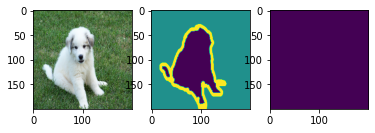

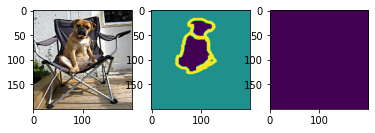

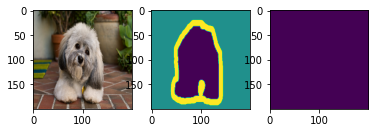

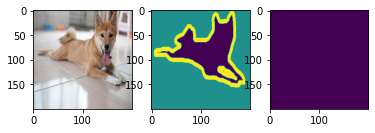

In [ ]:
dataset = dataset_test_original.map(lambda sample: encode(sample))

num_samples = 8
for image, segmentation_mask in dataset.take(num_samples):
  predicted_mask = model.predict(image.numpy().reshape((1,200,200,3))).squeeze()
  predicted_mask = np.argmax(predicted_mask, axis=-1)
  
  render_sample(image.numpy(), segmentation_mask.numpy().squeeze(),predicted_mask)